In [38]:
#@title Run This cell to import common modules. Double click on this if you want to take a look at the code 😀
'''
First, let's import a few common modules, ensure MatplotLib plots figures inline
and prepare a function to save the figures. We also check that Python 3.5 or 
later is installed (although Python 2.x may work, it is deprecated so we 
strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

You don't need to worry about understanding everything that is written 
in this section.
''';

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
rnd_seed = 42
rnd_gen = np.random.default_rng(rnd_seed)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [39]:
# Import the function used to fetch open ML datasets from scikit-learn
from sklearn.datasets import fetch_openml

# Fetch the dataset using the imported function
mnist = fetch_openml('mnist_784', # The identifier for the dataset 
                     version=1, # Which version to use
                     as_frame=False) #Should we load it as a dataframe?

In [41]:
# We'll load the data (i.e., the handwritten digit images) into variable X, and 
# the digit values (i.e., the corresponding numbers in the range 0 - 9) into y
X = mnist['data']
y = mnist['target'].astype(np.uint8)

In [42]:
#@title Data Rebalancing. Double click to see more!

# In this cell we'll be generating a smaller balanced dataset for faster 
# computations. By default, we'll choose 1000 samples of each digit in the dataset

# Here, we define how many digits within each class we'll keep
balanced_size = 1000

# Let's define some variable names as placeholders. If the variables aren't 
# initiated, we'll fully overwrite the variable with the balanced_sized list
# for the digit. Otherwise, we'll append the list.
bal_X = None
bal_y = None

# Looping through digit types, i.e.: 0,1,2,3,4,5,6,7,8,9
for digit in np.arange(0,10):
  
  # find the indices where the targets in _y_ are the digit of interest
  y_idxs = (y == digit)
  print(f'{digit} had {y_idxs.sum()} instances in the dataset. ', end='')
  
  # rnd_gen.choice picks n = balanced_size indices from the set of digit images 
  # available. We know the truth is an array with the same number of rows
  # as the subset, full of the current digit - we just need to make an array
  # full of the digit. 
  X_subset = X[y_idxs][rnd_gen.choice(np.arange(y_idxs.sum()),(balanced_size,))]
  y_subset = np.full(X_subset.shape[0],digit)

  # if bal_X is None, we'll overwrite bal_x and bal_y with the subsets.
  # Otherwise, we'll append stack the X/y subsets with bal_X/bal_y
  if bal_X is None:
    bal_X = X_subset
    bal_y = y_subset
  else:
    bal_X = np.vstack([bal_X, X_subset])
    bal_y = np.hstack((bal_y,y_subset))
  
  print(f'Digit {digit} has been rebalanced.')

# Shuffling the balanced dataset
shuffler = rnd_gen.permutation(len(bal_X))
bal_X = bal_X[shuffler]
bal_y = bal_y[shuffler]

0 had 6903 instances in the dataset. Digit 0 has been rebalanced.
1 had 7877 instances in the dataset. Digit 1 has been rebalanced.
2 had 6990 instances in the dataset. Digit 2 has been rebalanced.
3 had 7141 instances in the dataset. Digit 3 has been rebalanced.
4 had 6824 instances in the dataset. Digit 4 has been rebalanced.
5 had 6313 instances in the dataset. Digit 5 has been rebalanced.
6 had 6876 instances in the dataset. Digit 6 has been rebalanced.
7 had 7293 instances in the dataset. Digit 7 has been rebalanced.
8 had 6825 instances in the dataset. Digit 8 has been rebalanced.
9 had 6958 instances in the dataset. Digit 9 has been rebalanced.


In [44]:
# Splitting the dataset into train and test
from sklearn.model_selection import train_test_split

# set % of data to be used for testing
test_size=.10

# and split the dataset accordingly
X_train, X_test, y_train, y_test = train_test_split(
    bal_X, # the source of X data 
    bal_y, # the source of y data
    test_size = test_size, # the percent of data to retain as a test
    random_state = rnd_seed ) # set the random seed - consistent runs are important!

The image should be of a(n) 3


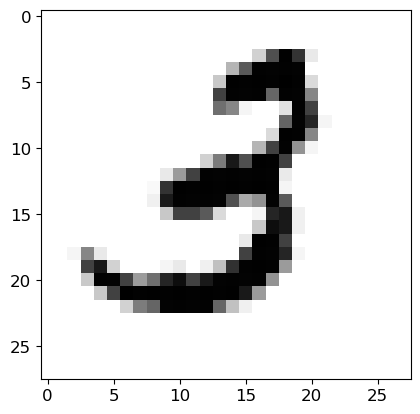

In [7]:
# Test that the label and image match. We're using np.random instead of our 
# rnd_gen since we don't want the runs of this snippet to vary the results in
# other snippets :) Run this as many times as you want!
test = np.random.randint(0,len(bal_X))
plt.imshow(bal_X[test].reshape((28,28)), cmap='Greys')
print(f'The image should be of a(n) {bal_y[test]}')

In [8]:
# Begin by importing the KNeighersClassifier and GridSearchCV from scikit.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [46]:

param_grid = {'weights':['uniform', 'distance'], # 1st hyperparameter and the values it can take
              'n_neighbors':[3, 4, 5, 6] # 2nd hyperparameter and the values it can take
}

In [48]:
# Instantiate the imported model class
knn_clf = KNeighborsClassifier()

In [49]:
# We define a grid search using the knn_clf model and param grid. We will set
# the number of folds for the cross-validation to 6, and use the most verbose
# setting to get the best idea of how well each cv run performs.


# Let's instantiate the scikit class used to do grid searches
grid_search = GridSearchCV( 
    knn_clf, # The model we're going to use in the search
    param_grid, # The method dictionary of parameters we'll iterate through in the search
    cv = 6, # The number of folds used to cross-validate
    verbose = 3) #Let's set the verbosity to the highest level: 3

In [51]:
# Complete the code
grid_search.fit(X_train,y_train)

Fitting 6 folds for each of 8 candidates, totalling 48 fits
[CV 1/6] END ....n_neighbors=3, weights=uniform;, score=0.936 total time=   0.6s
[CV 2/6] END ....n_neighbors=3, weights=uniform;, score=0.957 total time=   0.5s
[CV 3/6] END ....n_neighbors=3, weights=uniform;, score=0.951 total time=   0.5s
[CV 4/6] END ....n_neighbors=3, weights=uniform;, score=0.943 total time=   0.4s
[CV 5/6] END ....n_neighbors=3, weights=uniform;, score=0.945 total time=   0.4s
[CV 6/6] END ....n_neighbors=3, weights=uniform;, score=0.946 total time=   0.4s
[CV 1/6] END ...n_neighbors=3, weights=distance;, score=0.942 total time=   0.3s
[CV 2/6] END ...n_neighbors=3, weights=distance;, score=0.961 total time=   0.3s
[CV 3/6] END ...n_neighbors=3, weights=distance;, score=0.957 total time=   0.3s
[CV 4/6] END ...n_neighbors=3, weights=distance;, score=0.945 total time=   0.3s
[CV 5/6] END ...n_neighbors=3, weights=distance;, score=0.951 total time=   0.3s
[CV 6/6] END ...n_neighbors=3, weights=distance;,

GridSearchCV(cv=6, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 4, 5, 6],
                         'weights': ['uniform', 'distance']},
             verbose=3)

In [52]:
#Store the best parameters and best scores for the models
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

# And print them out. Try to make them nice!
print(f'Best Parameters: {best_parameters}',
      f'Best score: {best_score}',
      sep='\n')

Best Parameters: {'n_neighbors': 4, 'weights': 'distance'}
Best score: 0.953


In [53]:
#Import the accuracy metric
from sklearn.metrics import accuracy_score

In [54]:
#generate predictions from the best model
y_pred = grid_search.predict(X_test)

In [55]:
#calculate the accuracy score using the imported metric
accuracy = accuracy_score(y_test, y_pred)

In [56]:
# And print out the accuracy of the model
print(f'The accuracy of the model is {accuracy:.1%}')

The accuracy of the model is 96.9%


In [57]:
# We will import shift form the scipy multi-dimensional image processing tools
from scipy.ndimage.interpolation import shift

C:\Users\Justine Berg\AppData\Local\Temp\ipykernel_25124\1692431715.py:2: DeprecationWarning: Please import `shift` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import shift


In [63]:
# Using shift, we will write a function that shifts a single image left or right
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

In [64]:
# Let's choose a random image from out training dataset
rnd_id = rnd_gen.integers(0,
                          X_train.shape[0]) # dataset we're sampling

# And load the image associated with rnd_id from the dataset
image = X_train[rnd_id]

# Now, let's grab the same image as below and shift it down 5 pixels
shifted_image_down = shift_image(image, 
                                 0, # dx
                                 5) # dy

# and shift the original image left five pixels
shifted_image_left = shift_image(image, 
                                 -5, # dx 
                                 0) # dy


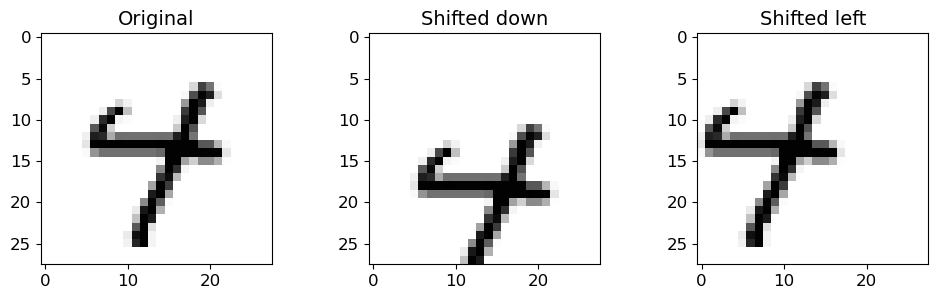

In [65]:
#@title Run this cell to plot the images we made in the cell above. You can always doubleclick it if you want to look at the source code 😀
# And then create a matplotlib figure where we'll plot the image
fig, axes = plt.subplots(1, # one row
                         3, # three columns
                         figsize=(12,3))

# Plot the original
axes[0].set_title("Original", fontsize=14)
axes[0].imshow(image.reshape(28, 28), # turn the flattened data back into a 28x28 image
          interpolation="nearest",
          cmap="Greys");

# Plot the down-shifted
axes[1].set_title("Shifted down", fontsize=14)
axes[1].imshow(shifted_image_down.reshape(28, 28), 
          interpolation="nearest", 
          cmap="Greys");

# Plot the left-shifted
axes[2].set_title("Shifted left", fontsize=14)
axes[2].imshow(shifted_image_left.reshape(28, 28), 
          interpolation="nearest", 
          cmap="Greys");

In [66]:
# transform the datasets into lists of images. This will make it easy to 
# iterate & append the shifted images
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

print(f'We have {len(X_train_augmented)} samples originally')

We have 9000 samples originally


In [68]:
# Make a tuple of shifts to apply to the datasets as augmentation.
# a shift of 1 pixel right and 1 up is recommended for the first shift tuple,
# and a shift of 1 pixel left, and 1 pixel down are recommended for the second tuple.
shifts = ((1,-1),
          (-1,1))

In [69]:
# Let's iterate through our shifts. Remember that each shift includes a value
# for dx and dy
for dx , dy in shifts:

    # For each shift defined, we'll iterate through the dataset to shift each 
    # image
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

In [71]:
# Transform the lists back into numpy arrays
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [72]:
#Let's print out the number of samples we have after augmenting!
print(f'We have {len(X_train_augmented)} samples after augmenting')

We have 27000 samples after augmenting


In [73]:
#@title Run this cell to shuffle the augmented data...

# Generate scrambled indices list
aug_shuffler = rnd_gen.permutation(len(X_train_augmented))

# Shuffle the array using the scrambled indices - that way the input data order
# matches the target data order
X_train_augmented = X_train_augmented[aug_shuffler]
y_train_augmented = y_train_augmented[aug_shuffler]

In [74]:
#Complete the code
knn_clf = KNeighborsClassifier( # The model class we're instantiating
    n_neighbors = grid_search.best_params_['n_neighbors'], # Load in our best number of neighbors
    weights = grid_search.best_params_['weights']) # Load in our best weight type

In [75]:
knn_clf.fit(X_train_augmented, # The input we're fitting 
            y_train_augmented) # The labels we're fitting

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [76]:
# Let's get the predictions from our model
y_pred = knn_clf.predict(X_test)

# And use them to calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

# We'll finish by printing out our accuracy...
print(f'The accuracy for our model training on augmented data is {accuracy:.1%}!')

The accuracy for our model training on augmented data is 97.5%!


In [ ]:
######## Excercise 2 ########

In [77]:
#@title `fetch_titanic_data` and `load_titanic_data` definition. Double click here to see the source code.
# Setup - First, We need to fetch the data from the internet...
import os
import urllib.request
import pandas as pd


TITANIC_PATH = os.path.join(PROJECT_ROOT_DIR,"datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/titanic/"

# Define the function that will download the titanic data... 
def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ("train.csv", "test.csv"):
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print("Downloading", filename)
            urllib.request.urlretrieve(url + filename, filepath)

# And define the function that loads the data into memory...
def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [78]:
# Let's start by fetching the titanic data
fetch_titanic_data()

In [79]:
# And load the training data and test data 
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

In [81]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [80]:
# We will explicitely set the PassengerId attribute as the DataFrame index 
# since it is unique to each passenger
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

In [83]:
# Calculate the median and standard deviation for the age of passengers listed
# as having a female sex
med_age_f = train_data[train_data["Sex"]=="female"]["Age"].median()
stddev_age_f = train_data[train_data["Sex"]=="female"]["Age"].std()

# Calculate the median and standard deviation for the age of passengers listed
# as having a male sex
med_age_m = train_data[train_data["Sex"]=="male"]["Age"].median()
stddev_age_m = train_data[train_data["Sex"]=="male"]["Age"].std()

print_out=(f'The female population had a median age of {med_age_f:.1f}'
           f' with a standard deviation of {stddev_age_f:.2f} \n'
           f'The male population had a median age of {med_age_m:.1f}'
           f' with a standard deviation of {stddev_age_m:.2f} \n')

print(print_out)

The female population had a median age of 27.0 with a standard deviation of 14.11 
The male population had a median age of 29.0 with a standard deviation of 14.68 



In [84]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [85]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [86]:
#@title Use this cell to print out the values and counts of the catergorical classes... 
# Initialize the string
print_out = ""

# Define the columns to iterate through 
var_list = ["Survived", "Pclass", "Sex", "Embarked"]

# Append the information to our print out text by iterating
for var in var_list: print_out += f'{train_data[var].value_counts()} \n\n'

# and print out the final string
print(print_out)

Survived
0    549
1    342
Name: count, dtype: int64 

Pclass
3    491
1    216
2    184
Name: count, dtype: int64 

Sex
male      577
female    314
Name: count, dtype: int64 

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64 




In [87]:
# Let's import the classes we'll need from scikit-learn in order to set up
# our data pipeline.
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# The Pipeline needs to be initiated with a list containing the name of the
# preprocessor (e.g., "imputer" or "scaler").
num_pipeline = Pipeline([ # We'll instantiate the pipeline class
     ("imputer", SimpleImputer(strategy="median")), # Which will use the imputer
     ("scaler", StandardScaler() ) ]) # as well as the scaler

In [89]:
# Let's import the One Hot Encoder function from scikit-learn, and set up our
# categorical data pipeline
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline( [ # Once again we instantiate the pipeline class
    ("imputer", SimpleImputer(strategy="most_frequent")), # And set up an imputer with a strategy
    ("cat_encoder", OneHotEncoder(sparse_output = False)) ] ) # and an encoder with a given sparsity parameter

In [90]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer( [("num", num_pipeline, num_attribs),
                                          ("cat", cat_pipeline, cat_attribs) ] )

In [91]:
# Let's preprocess our datasets!
X_train = preprocess_pipeline.fit_transform( # Fit your pipeline using the training input data and transform the training input data in one step!
              train_data[cat_attribs + num_attribs] ) # load the categorical and numerical attributes from the training dataframe

X_test =  preprocess_pipeline.transform( # Transform the testing input data and transform the training data in one step!
              test_data[cat_attribs + num_attribs] ) # load the categorical and numerical attributes from the testing dataframe

y_train = train_data["Survived"] # Load whether or not the passengers in the training survived into y_train

# You might be wondering about y_test. Remember, since the data came from a
# Kaggle competition, we don't actually have y_test! 

In [92]:
#@title Let's print a sample to take a loot at the data being produced
for idx, attrib in np.ndenumerate(np.hstack((num_attribs,cat_attribs))):
    print(f"{attrib} has a value of {X_train[0][idx]}")

Age has a value of -0.5657358173332453
SibSp has a value of 0.4327933656785018
Parch has a value of -0.4736736092984604
Fare has a value of -0.5024451714361923
Pclass has a value of 0.0
Sex has a value of 0.0
Embarked has a value of 1.0


In [93]:
# Let's import the scikit implementation of random forest classifiers
from sklearn.ensemble import RandomForestClassifier

In [94]:
# And now let's instantiate the RandomForestClassifier class
forest_clf = RandomForestClassifier(n_estimators=100, # Set our number of estimators 
                                    random_state=rnd_seed) # And set our random seed for consistent results

In [95]:
# We end by fitting the model
forest_clf.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [96]:
# Let's import the accuracy score implementation in scikit-learn
from sklearn.metrics import accuracy_score

# Then let's get predictions from our model
y_pred = forest_clf.predict(X_train)

# Let's calculate the accuracy...
accuracy = accuracy_score(y_train, # We'll need our ground truth
                   y_pred) # and our predictions
print(f'The accuracy we got on our training dataset is {accuracy:.1%}')

The accuracy we got on our training dataset is 98.0%


In [97]:
# Let's start by importing the cross validation score class from scikit-learn
from sklearn.model_selection import cross_val_score

# Let's instantiate the imported class...
forest_scores = cross_val_score(forest_clf, # Which will need the model to evaluate 
                                X_train, # The input data to use
                                y_train, # The corresponding target data
                                cv=10) # And the number of folds for evaluation

print(f'The mean score is {forest_scores.mean():.1%}')

The mean score is 81.4%


In [98]:
# Let's import the SVC class and instantiate a model
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")

svm_scores = cross_val_score(svm_clf,
                     X_train,
                     y_train,
                     cv=10)
print(f'The mean score is {svm_scores.mean():.1%}')

The mean score is 82.5%


C:\Users\Justine Berg\AppData\Local\Temp\ipykernel_25124\1670732353.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))


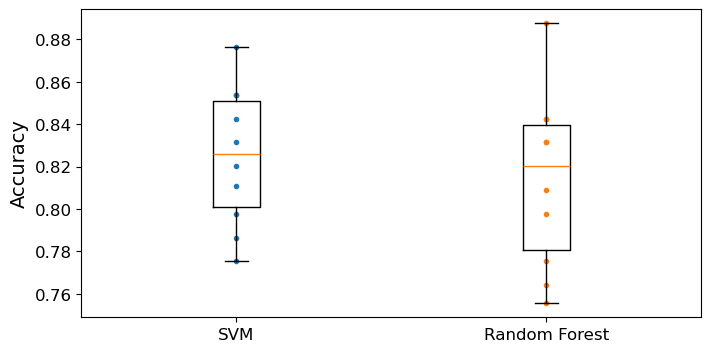

In [99]:
#@title We'll make a quick boxplot to compare the SVM and Random Forest CV scores
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

In [ ]:
######### Excercise 2.3 #########

In [100]:
#@title  Run this cell for preliminary requirements. Double click it if you want to check out the source :)

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To make this notebook's output stable across runs
rnd_seed = 42
rnd_gen = np.random.default_rng(rnd_seed)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

#Ensure the palmerspenguins dataset is installed
%pip install palmerpenguins --quiet

Note: you may need to restart the kernel to use updated packages.


In [101]:
# Let's load the Palmer Penguins Dataset!
from palmerpenguins import load_penguins
data = load_penguins()

In [102]:
data.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [107]:
# We define the species that we're interested in
species = ['Adelie','Gentoo']

# And use the .loc method in Pandas to keep only the two species mentioned above
data = data.loc[data['species'].isin(species)]

In [110]:
import nbformat
print(nbformat.__version__)

5.10.4


In [117]:
# Load the bill length and depth into X
X = data[['bill_length_mm', 'bill_depth_mm']]

# Find out the rows where you don't have an valid input (i.e., rows with a nan value)
indices = X.notna().all(axis=1)

# Filter out the datapoints using the indices we found
X = X[indices]

# We'll also normalize the data using the mean and standard deviation
X = (X - X.mean())/X.std()

In [118]:
# Let's take a look at the input dataset - if you did everything right, you'll 
# have 274 entries and printing out x.shape will return (274,2)
print(X.shape)

(274, 2)


In [121]:
# Convert species data into boolean form by checking if the species is Adélie
y = (data['species'] == 'Adelie')

# Filter out the points for which we have NaN values. Reuse the indices from Q1! 
y = y[indices]

# Convert the boolean data into an integer
y = y.astype(int)

In [122]:
# Print out y! If everything is implemented correctly, you should see a panda 
# series full of ones and zeroes with 274 rows
print(y)

0      1
1      1
2      1
4      1
5      1
      ..
270    0
272    0
273    0
274    0
275    0
Name: species, Length: 274, dtype: int64


In [123]:
#@title Hint - Exponential Function
'''
Numpy includes the exponential function in its library as numpy.exp
https://numpy.org/doc/stable/reference/generated/numpy.exp.html
''';

np.exp(2);

In [127]:
def logistic(in_val):
    # Return the value of the logistic function
    out_value = 1 / (1 + np.exp(-in_val))
    return out_value

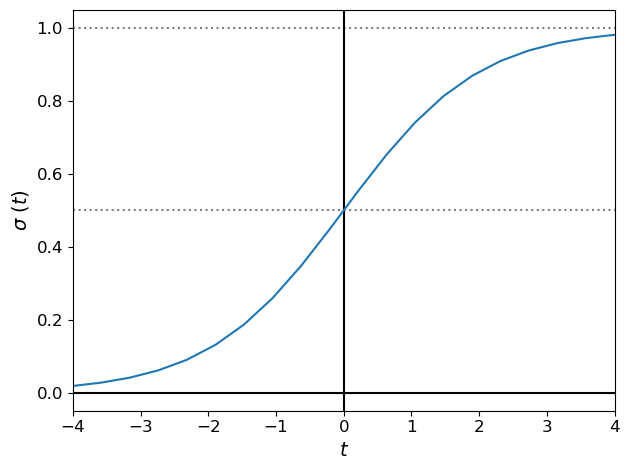

In [128]:
#@title Run this to plot the logistic function!
# Let's generate an array of 20 points with values from -4 to +4 
t = np.linspace(-4,4,20)

# Initiate a figure and axes object using matplotlib
fig, ax = plt.subplots()

# Draw the X and Y axes
ax.axvline(0, c='black', alpha=1)
ax.axhline(0, c='black', alpha=1)

# Draw the threshold line (y_val=0,5) and asymptote (y=1)
[ax.axhline(y_val, c='black', alpha=0.5, linestyle='dotted') for y_val in (0.5,1)]

# Scale things to make the graph look nicer
plt.autoscale(axis='x', tight=True)

# Plot the logistic function. X values from the t vector, y values from logistic(t)
ax.plot(t, logistic(t));
ax.set_xlabel('$t$')
ax.set_ylabel('$\\sigma\\  \\left(t\\right)$')
fig.tight_layout()

In [129]:
rnd_gen.random((3,)) # length of array

array([0.77395605, 0.43887844, 0.85859792])

In [130]:
theta = rnd_gen.random((3,))

In [132]:
assert X.shape==y.shape

AssertionError: 

In [133]:
print(X.shape)
print(y.shape)

(274, 2)
(274,)


In [148]:
def log_loss(p_hat, y, epsilon=1e-7):
    # Ensure that p_hat and y have the same shape
    assert p_hat.shape == y.shape, "Predictions and true values must have the same shape"
    
    # Calculate the two terms of the log loss function
    term_1 = -np.log(p_hat + epsilon)  # Avoid log(0) by adding epsilon
    term_2 = -np.log(1 - p_hat + epsilon)  # Same for 1 - p_hat
    
    # Combine the terms with the corresponding y and (1 - y)
    inside_brackets = y * term_1 + (1 - y) * term_2
    
    # Verify the shape of inside_brackets (should match p_hat and y)
    print(f'The size of the term inside the brackets is {inside_brackets.shape}')
    
    # Calculate the mean log loss (cost function)
    J = inside_brackets.mean()
    
    return J

In [137]:
# Generate the ones array
ones_array = np.ones(X.shape[0])

# Make the x_with_bias matrix
X_with_bias = np.c_[ones_array, X]

In [138]:
# Print your x with bias matrix to make sure it looks the way it's supposed to
print(X_with_bias[:10])

[[ 1.         -0.69346042  0.92572752]
 [ 1.         -0.6164717   0.28005659]
 [ 1.         -0.46249427  0.57805856]
 [ 1.         -1.15539273  1.22372949]
 [ 1.         -0.65496606  1.86940041]
 [ 1.         -0.73195478  0.47872457]
 [ 1.         -0.67421324  1.37273047]
 [ 1.         -1.65581939  0.62772555]
 [ 1.         -0.13529222  1.67073244]
 [ 1.         -0.94367375  0.13105561]]


In [139]:
# Write your predict function here
def predict_function( X_with_bias, theta):
    # Find the dot product of X_with_bias and theta
    dot_product = np.dot(X_with_bias, theta)

    # Use your logistic function!
    output = logistic(dot_product)

    return output # Return the value you get

In [140]:
# Let's test your predict function!

# Set up debug data and parameters
debug_data = np.c_[np.ones(5), np.linspace(-1,1,10).reshape((-1,2))]
debug_theta = np.array([0.2,0.1,0.9]) 

print(predict_function(debug_data, debug_theta))

[0.35434369 0.46118934 0.57172409 0.67553632 0.76454801]


In [141]:
def gradient_calculator(y, X_with_bias, theta):
    # Find predicted values using the predict function
    prediction = predict_function(X_with_bias, theta)

    # Assert that you have the same number of predictions as you do targets
    # Otherwise, something went wrong!
    assert len(prediction) == len(y)

    # Calculate the error
    error = prediction - y
    
    # Transpose X_with_bias
    X_transpose = X_with_bias.T

    # Find the dot product with the input matrix and divide by the number of 
    # predictions
    output =  np.dot(X_transpose, error) / len(prediction)
    return output

In [ ]:
def gradient_calculator(y, X_with_bias, theta_vector):
    # Get predicted values using the predict function
    prediction = predict_function(X_with_bias, theta_vector)
    
    # Assert that you have the same number of predictions as you do targets
    assert len(prediction) == len(y)
    
    # Calculate the error
    error = prediction - y
    
    # Transpose X_with_bias
    X_transpose = X_with_bias.T
    
    # Calculate the gradient: dot product of X_transpose and error, divided by the number of predictions
    gradient = np.dot(X_transpose, error) / len(prediction)
    
    return gradient

# Testing the gradient_calculator
debug_labels = np.array([0, 0, 0, 1, 1])
print(gradient_calculator(debug_labels, debug_data, debug_theta))

In [142]:
# Let's test the gradient calculator
# Begin by creating dummy labels
debug_labels = np.array([0,0,0,1,1])

# And call the function you defined with the dummy labels and data we made before
print(gradient_calculator(debug_labels, debug_data, debug_theta))

[ 0.16546829 -0.19307376 -0.15630302]


In [150]:
def logistic_regression(X_train,
                        y_train,
                        X_validation,
                        y_validation,
                        theta_vector,
                        num_iters,
                        learning_rate,
                      ):
  # Initialize the list of losses
  training_losses = []
  validation_losses = []
  
  # Loop through as many times as defined in the function call
  for iteration in range(num_iters):
    
    #--------Training-------
    # Get predictions on training dataset
    train_predictions = predict_function(X_train, theta_vector)
    
    # Calculate the loss
    train_loss = log_loss(train_predictions, y_train)

    # Add it to the list of training losses to keep track of it
    training_losses.append(train_loss)
    
    # Calculate the Gradient
    gradient = gradient_calculator(y_train, X_train, theta_vector)
    
    # Find the new value of theta
    theta_vector = theta_vector - learning_rate * gradient

    #--------Validation-----------
    # Get predictions on the validation dataset
    validation_predictions = predict_function(X_validation, theta_vector)

    # Calculate the validation loss
    validation_loss = log_loss(validation_predictions, y_validation)

    # Add it to the list of validation losses to keep track of it
    validation_losses.append(validation_loss)
    
    # Progress Indicator
    if (iteration/num_iters * 100) % 5 == 0:
      print(f'\rCompleted {(iteration)/(num_iters)*100}%', end='')
  
  print('\rCompleted 100%')
  return [training_losses, validation_losses], theta_vector

In [151]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

rnd_indices = rnd_gen.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y.iloc[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y.iloc[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y.iloc[rnd_indices[-test_size:]]

In [152]:
# Complete the code
losses, coeffs = logistic_regression(X_train,
                          y_train,
                          X_valid,
                          y_valid,
                          theta, 
                          num_iters = 500,
                          learning_rate = 0.1,
                          )

The size of the term inside the brackets is (166,)
The size of the term inside the brackets is (54,)
Completed 0.0%The size of the term inside the brackets is (166,)
The size of the term inside the brackets is (54,)
The size of the term inside the brackets is (166,)
The size of the term inside the brackets is (54,)
The size of the term inside the brackets is (166,)
The size of the term inside the brackets is (54,)
The size of the term inside the brackets is (166,)
The size of the term inside the brackets is (54,)
The size of the term inside the brackets is (166,)
The size of the term inside the brackets is (54,)
The size of the term inside the brackets is (166,)
The size of the term inside the brackets is (54,)
The size of the term inside the brackets is (166,)
The size of the term inside the brackets is (54,)
The size of the term inside the brackets is (166,)
The size of the term inside the brackets is (54,)
The size of the term inside the brackets is (166,)
The size of the term insid

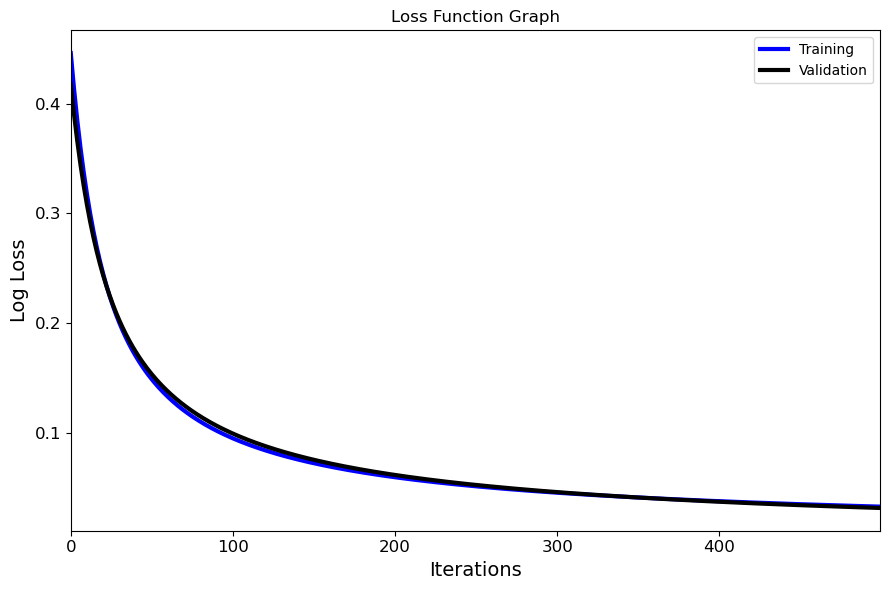

In [153]:
#@title Run this cell to produce the Loss Function Visualization Graphs
fig, ax = plt.subplots(figsize=(9,6), dpi=100)
ax.plot(losses[0], color='blue', label='Training', linewidth=3);
ax.plot(losses[1], color='black', label='Validation', linewidth=3);
ax.legend();
ax.set_ylabel('Log Loss')
ax.set_xlabel('Iterations')
ax.set_title('Loss Function Graph')
ax.autoscale(axis='x', tight=True)
fig.tight_layout();

In [155]:
# Let's get predictions from our model for the training, validation, and testing
# datasets
y_hat_train = (predict_function(X_train, coeffs)>=.5).astype(int)
y_hat_valid = (predict_function(X_valid, coeffs)>=.5).astype(int)
y_hat_test = (predict_function(X_test, coeffs)>=.5).astype(int)

y_sets = [ [y_hat_train, y_train],
           [y_hat_valid, y_valid],
           [y_hat_test, y_test] ]

def accuracy_score(y_hat, y):
    assert(y_hat.size==y.size)
    return (y_hat == y).sum()/y.size
accuracies=[]
[accuracies.append(accuracy_score(y_set[0],y_set[1])) for y_set in y_sets]

printout= (f'Training Accuracy:{accuracies[0]:.1%} \n'
           f'Validation Accuracy:{accuracies[1]:.1%} \n'
           f'Test Accuracy:{accuracies[2]:.1%} \n')

# Add the testing accuracy only once you're sure that your model works!
print(printout)

Training Accuracy:99.4% 
Validation Accuracy:100.0% 
Test Accuracy:100.0% 



In [ ]:
################# Excercise 2.5 #################

In [3]:
#@title Run this cell to get the python environment set up!
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import pandas as pd
import pooch


# to make this notebook's output stable across runs
rnd_seed = 42
rnd_gen = np.random.default_rng(rnd_seed)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
#@title And this cell to load the data we'll be using as `A3_df`
#Loading Wilks' Table A-3 from the course datastore
csv_path = 'https://unils-my.sharepoint.com/:x:/g/personal/tom_beucler_unil_ch/EXG7Rht55mhPiwkUKEDSI8oBuXNe8OOLYJX3_5ACmK1w5A?download=1'
hash = 'c158828a1bdf1aa521c61321842352cb1674e49187e21c504188ab976d3a41f2'
csv_file = pooch.retrieve(csv_path, known_hash=hash)

A3_df = pd.read_csv(csv_file, index_col=0)
print("Here's a data sample. You can copy the row header text from here if you need it later 😉")
A3_df.head(5)

Here's a data sample. You can copy the row header text from here if you need it later 😉


,El Niño,Temperature (°C),Precipitation (mm),Pressure (mb)
Year,,,,
1951,1,26.1,43,1009.5
1952,0,24.5,10,1010.9
1953,1,24.8,4,1010.7
1954,0,24.5,0,1011.2
1955,0,24.1,2,1011.9


In [5]:
# Import the LinearRegression model
from sklearn.linear_model import LinearRegression

In [7]:
# Instantiate the model
lin_reg = LinearRegression()

In [8]:
# Load and reshape the input data
pressure = A3_df['Pressure (mb)'].values.reshape(-1,1)

In [9]:
# Load the truth data (i.e., the predictant)
temperature = A3_df['Temperature (°C)'].to_numpy().ravel()

In [10]:
# Fit the model
lin_reg.fit(pressure, temperature)

LinearRegression()

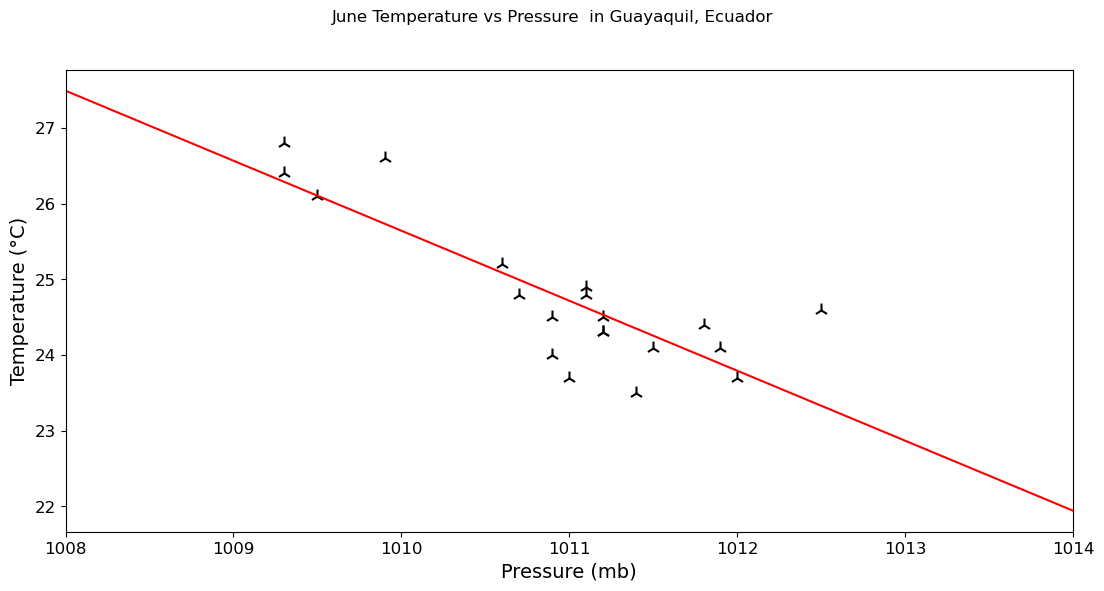

In [15]:
#Instantiate a figure having size 13,6
fig, ax = plt.subplots(figsize=(13,6))

"""---------------------------------------------------------------------------- 
Let's start by plotting the data points from our dataset
----------------------------------------------------------------------------"""
# Set figure title and axis labels
fig.suptitle('June Temperature vs Pressure  in Guayaquil, Ecuador')
ax.set_xlabel("Pressure (mb)")
ax.set_ylabel("Temperature (°C)")

# The colors and styles suggested below are not compulsory, but please avoid 
# using the default settings.
# Make a scatter plot for the pressure (x) and temperature (y). Use color=black,
# marker size = 100, and set the marker style to '2'.

ax.scatter(pressure, # X values
           temperature, # y values
           color = 'black', # Color
           s = 100, # Marker size
           marker = '2') # Marker style


'''---------------------------------------------------------------------------- 
Now, let's plot the line we fit to the datapoints
----------------------------------------------------------------------------'''
# Make a 100 point numpy array between 1008 and 1014 and store it in reg_x. 
# Reshape it to (-1,1). Hint: numpy has a linear space generator
reg_x = np.linspace(1008, # Start
                        1014, # Stop
                        100,# Number of Points
                        ).reshape(-1, 1) # Reshape to row=sample, col=feature

# Let's produce a set of predictions from our linear space array.
reg_y = lin_reg.predict(reg_x)

# Let's plot the regression line using reg_x and reg_y. Set the color to red and
# the linewidth to 1.5
ax.plot(reg_x, # X
        reg_y, # y
        color = 'red', # Color
        linewidth = 1.5) # Linewidth

ax.autoscale(axis='x', tight=True)

In [23]:
# Fetch the slope directly from the linear model. Hint: check the attributes 
# section of the linear regression model documentation on scikit.
slope = lin_reg.coef_[0]
slope = float(slope)

# Calculate the F-score and p-value for our dataset.
# Hint: check the f_regression option in sklearn.feature_selection
from sklearn.feature_selection import f_regression
fscore, pvalue = f_regression(pressure.reshape(-1, 1), # X values
                         temperature) # y values
fscore=float(fscore)
pvalue=float(pvalue)


# Fetch the R2 value from the lin_reg model. Hint: r2_score in sklearn metrics
predicted_temperatures = lin_reg.predict(pressure.reshape(-1, 1))
from sklearn.metrics import r2_score
R_squared = r2_score(temperature, # Ground truth
                    predicted_temperatures) # Predictions

C:\Users\Justine Berg\AppData\Local\Temp\ipykernel_15280\1196340373.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fscore=float(fscore)
C:\Users\Justine Berg\AppData\Local\Temp\ipykernel_15280\1196340373.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pvalue=float(pvalue)


In [24]:
# Now we print out the results!
print(f'The slope of the line is: {slope:.2f}',
      f'The f score is: {fscore:.0f}',
      f'The R\u00b2 value is: {R_squared:.2f}',
      sep='\n')

The slope of the line is: -0.92
The f score is: 40
The R² value is: 0.69


In [25]:
#@title Run this cell to set up the `test` and `train` year lists
# Let's make our train and test datasets
def test_train_split(df, rnd_gen):
    nino_years = df.loc[df['El Niño']==1].index.values
    not_nino_years = df.loc[df['El Niño']==0].index.values

    nino_idxs = rnd_gen.permutation(np.arange(0,nino_years.size))
    not_nino_idxs = rnd_gen.permutation(np.arange(0,not_nino_years.size))

    train = ( list(nino_years[nino_idxs[:-1]]) +
              list(not_nino_years[not_nino_idxs[:-1]]) )
  
    test = [nino_years[nino_idxs[-1]], not_nino_years[not_nino_idxs[-1]]]
    
    return (np.array(test), np.array(train))

# Use test_train_split to make the testing and training datasets
test, train = test_train_split(A3_df, rnd_gen)
print(f'Test years: {test}\n'
      f'Train years: {train}')

Test years: [1951 1958]
Train years: [1969 1957 1965 1953 1970 1963 1968 1961 1967 1964 1960 1962 1956 1952
 1954 1959 1966 1955]


In [26]:
#@title Let's print out the dataframe head to remember the header columns...
A3_df.head(5)

,El Niño,Temperature (°C),Precipitation (mm),Pressure (mb)
Year,,,,
1951,1,26.1,43,1009.5
1952,0,24.5,10,1010.9
1953,1,24.8,4,1010.7
1954,0,24.5,0,1011.2
1955,0,24.1,2,1011.9


In [35]:
# Get the training and testing dataframes
train_df = A3_df.loc[train]
test_df = A3_df.loc[test]

# Extract the training inputs (X_train) and labels (y_train) from 
# the training dataframe
X_train = train_df[['Pressure (mb)','Temperature (°C)']].to_numpy()
y_train = train_df[['El Niño']].values.ravel()

# Do the same with the testing dataframe
X_test = test_df[['Pressure (mb)','Temperature (°C)']].to_numpy()
y_test = test_df[['El Niño']].values.ravel()

In [36]:
# Import the LogisticRegression class from sklearn
from sklearn.linear_model import LogisticRegression

# And instantiate the model
log_reg = LogisticRegression()

In [37]:
log_reg.fit(X_train, y_train)

LogisticRegression()

In [39]:
# Make predictions using our model!
prediction = log_reg.predict(X_test)

In [40]:
print(f'Was {test[0]} an El Niño year? {bool(y_test[0])}. We predicted {bool(prediction[0])}')
print(f'Was {test[1]} an El Niño year? {bool(y_test[1])}. We predicted {bool(prediction[1])}')

Was 1951 an El Niño year? True. We predicted True
Was 1958 an El Niño year? False. We predicted False
